<a href="https://colab.research.google.com/github/RohanSaxena14/facial_keypoint_detection/blob/master/facial_keypoints_68_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

mkdir: cannot create directory ‘/data’: File exists
--2020-05-09 17:52:21--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.236.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.236.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 338613624 (323M) [application/zip]
Saving to: ‘/data/train-test-data.zip.1’

train-test-data.zip 100%[===================>] 322.93M  35.2MB/s    in 9.9s    

2020-05-09 17:52:31 (32.5 MB/s) - ‘/data/train-test-data.zip.1’ saved [338613624/338613624]

Archive:  /data/train-test-data.zip


In [0]:
import pandas as pd

key_points_train = pd.read_csv("/data/training_frames_keypoints.csv")
key_points_test = pd.read_csv("/data/test_frames_keypoints.csv")

print(key_points_train.head())
print(key_points_test.head())

                   Unnamed: 0     0     1     2  ...   132    133   134    135
0           Luis_Fonsi_21.jpg  45.0  98.0  47.0  ...  81.0  122.0  77.0  122.0
1       Lincoln_Chafee_52.jpg  41.0  83.0  43.0  ...  83.0  122.0  79.0  122.0
2       Valerie_Harper_30.jpg  56.0  69.0  56.0  ...  75.0  105.0  73.0  105.0
3         Angelo_Reyes_22.jpg  61.0  80.0  58.0  ...  91.0  139.0  85.0  136.0
4  Kristen_Breitweiser_11.jpg  58.0  94.0  58.0  ...  88.0  122.0  84.0  122.0

[5 rows x 137 columns]
                   Unnamed: 0     0     1     2  ...   132    133   134    135
0     James_Wolfensohn_00.jpg  25.0  44.0  25.0  ...  39.0   65.0  38.0   65.0
1       Valerie_Harper_30.jpg  55.0  62.0  52.0  ...  75.0  104.0  70.0  104.0
2  Kristen_Breitweiser_11.jpg  60.0  88.0  60.0  ...  94.0  117.0  89.0  117.0
3       Elizabeth_Dole_31.jpg  41.0  96.0  43.0  ...  96.0  122.0  94.0  122.0
4             Kit_Bond_20.jpg  35.0  67.0  37.0  ...  73.0   98.0  69.0   98.0

[5 rows x 137 columns]


In [0]:
import os
import torch
import numpy as np
import tensorflow as tf
import torchvision.transforms as T
from google.colab.patches import cv2_imshow
from PIL import Image

preprocess = T.Compose([
                          T.Grayscale(num_output_channels=1),
                          T.Resize((250, 250)),
                          T.RandomCrop(224),
                          T.ToTensor(),
])

tensor_lst_train, train_labels = [], []
tensor_lst_test, test_labels = [], []

for i in range(3462):
  image_name = key_points_train.iloc[i, 0]
  img = Image.open("/data/training/" + str(image_name))
  img = preprocess(img).reshape(224, 224, 1)
  tensor_lst_train.append(img)
  train_labels.append(list(key_points_train.iloc[i, 1:]))

the_image = image_name

for i in range(770):
  image_name = key_points_test.iloc[i, 0]
  img = Image.open("/data/training/" + str(image_name))
  img = preprocess(img).reshape(224, 224, 1)
  tensor_lst_test.append(img)
  test_labels.append(list(key_points_test.iloc[i, 1:]))

In [0]:
'''
mean_train = np.mean(train_labels)
train_labels -= mean_train
std_train = np.std(train_labels)
train_labels /= std_train

mean_test = np.mean(test_labels)
test_labels -= mean_test
std_test = np.std(test_labels)
test_labels /= std_test


print(mean_train, std_train)
print(mean_test, std_test)
'''

'\nmean_train = np.mean(train_labels)\ntrain_labels -= mean_train\nstd_train = np.std(train_labels)\ntrain_labels /= std_train\n\nmean_test = np.mean(test_labels)\ntest_labels -= mean_test\nstd_test = np.std(test_labels)\ntest_labels /= std_test\n\n\nprint(mean_train, std_train)\nprint(mean_test, std_test)\n'

In [0]:
print(max(train_labels[0]))
print(min(train_labels[0]))

139.0
45.0


In [0]:
train_data  = torch.stack(tensor_lst_train)
train_labels = np.array(train_labels)

test_data  = torch.stack(tensor_lst_test)
test_labels = np.array(test_labels)

train_data.shape
test_data.shape

torch.Size([770, 224, 224, 1])

In [0]:
np_tensor_train = train_data.numpy()
np_tensor_test = test_data.numpy()


train_data = tf.convert_to_tensor(np_tensor_train)
test_data = tf.convert_to_tensor(np_tensor_test)

print(train_data.shape)
print(test_data.shape)

(3462, 224, 224, 1)
(770, 224, 224, 1)


In [0]:
from tensorflow import keras

model = keras.Sequential([
                          keras.layers.Conv2D(32, (5, 5), activation = 'relu', input_shape = train_data.shape[1:]),
                          keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
                          keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
                          keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
                          keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
                          keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
                          keras.layers.Conv2D(256, (3, 3), activation = 'relu'),
                          keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
                          keras.layers.Conv2D(512, (1, 1), activation = 'relu'),
                          keras.layers.MaxPooling2D(pool_size = (2, 2), strides = (2, 2)),
                          keras.layers.Flatten(),
                          keras.layers.Dense(1024, activation = 'relu'),
                          keras.layers.Dropout(0.5),
                          keras.layers.Dense(136)
])

In [0]:
model.compile(optimizer = 'adam', loss = keras.losses.MSE)

In [0]:
model.fit(train_data, train_labels, epochs = 15, batch_size = 10, validation_split = 0.1)

Epoch 1/15
312/312 [==============================] - 8s 25ms/step - loss: 2133.5330 - val_loss: 1166.0745
Epoch 2/15
312/312 [==============================] - 7s 24ms/step - loss: 1453.9045 - val_loss: 1226.8583
Epoch 3/15
312/312 [==============================] - 7s 24ms/step - loss: 1344.6162 - val_loss: 1091.2969
Epoch 4/15
312/312 [==============================] - 7s 24ms/step - loss: 1270.2451 - val_loss: 1127.0947
Epoch 5/15
312/312 [==============================] - 7s 24ms/step - loss: 1223.7670 - val_loss: 1088.1301
Epoch 6/15
312/312 [==============================] - 7s 24ms/step - loss: 1222.5342 - val_loss: 985.1915
Epoch 7/15
312/312 [==============================] - 7s 24ms/step - loss: 1121.6268 - val_loss: 944.0142
Epoch 8/15
312/312 [==============================] - 7s 24ms/step - loss: 1050.2827 - val_loss: 936.7529
Epoch 9/15
312/312 [==============================] - 7s 24ms/step - loss: 976.1664 - val_loss: 892.6360
Epoch 10/15
312/312 [=====================

In [0]:
p = model.evaluate(test_data, test_labels)
print(p)

25/25 [==============================] - 0s 19ms/step - loss: 691.3973
691.3973388671875


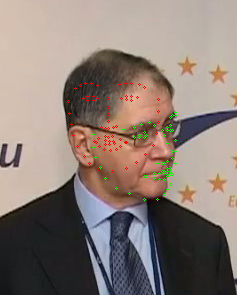

In [0]:
import cv2
from google.colab.patches import cv2_imshow

img = Image.open("/data/training/" + str(the_image))

img_temp = preprocess(img).reshape(224, 224, 1).unsqueeze(0).numpy()
image_tensor = tf.convert_to_tensor(img_temp)

predictions = model.predict(image_tensor)[0].astype(int)
#predictions = ((predictions * std_train) + mean_train).astype(int)

actual = train_labels[-1].astype(int)
#actual = ((actual * std_train) + mean_train).astype(int)

img = cv2.imread("/data/training/" + str(the_image), 1)

for i in range(1, 69):
  points = tuple(predictions[2*(i-1) : 2*i])
  img = cv2.circle(img, points, 1, (0, 0, 255), 1)
  points = tuple(actual[2*(i-1) : 2*i])
  img = cv2.circle(img, points, 1, (0, 255, 0), 1)


cv2_imshow(img)